<a href="https://colab.research.google.com/github/emiresenov/PRPD-Classification/blob/main/PRPD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys, zipfile, pathlib, random
from pathlib import Path

import numpy as np
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


TensorFlow: 2.19.0
GPU available: True


# Data collection and processing

In [2]:
ZIP_URL = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/xz4xhrc4yr-7.zip"

DATA_DIR = Path("/content")
ZIP_PATH = DATA_DIR / "pd.zip"
RAW_DIR = DATA_DIR / "pd_raw"

!wget -q -O "$ZIP_PATH" "$ZIP_URL"

RAW_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(RAW_DIR)

for p in list(RAW_DIR.glob("*"))[:10]:
    print(p)


/content/pd_raw/Images of resolved phase patterns of partial discharges in electric generators


In [3]:
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

LABEL_CANON = {
    "internal": "internal",
    "corona": "corona",
    "surface": "surface",
    "superficial": "surface",
}

def find_label_from_path(path: Path):
    for part in reversed(path.parts):
        key = part.lower()
        if key in LABEL_CANON:
            return LABEL_CANON[key]
    lower = [p.lower() for p in path.parts]
    for key in LABEL_CANON:
        if any(key in seg for seg in lower):
            return LABEL_CANON[key]
    return None

all_imgs = []
for p in RAW_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        lbl = find_label_from_path(p.parent)
        if lbl is not None:
            all_imgs.append((str(p), lbl))

print(f"Found {len(all_imgs)} labeled images.")
labels = sorted(set(lbl for _, lbl in all_imgs))
print("Labels:", labels)

from collections import Counter
cnt = Counter(lbl for _, lbl in all_imgs)
print("Per-class counts:", cnt)

assert len(labels) >= 2, "Did not detect at least two classes. Check extracted folders."


Found 945 labeled images.
Labels: ['corona', 'internal', 'surface']
Per-class counts: Counter({'internal': 321, 'surface': 316, 'corona': 308})


In [4]:
from pathlib import Path
from collections import Counter
import shutil

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

RAW_DIR = Path("/content/pd_raw")   # path where dataset was extracted
TEST_REAL_DIR = Path("/content/pd_test_real")  # new folder for clean test data

TEST_REAL_DIR.mkdir(parents=True, exist_ok=True)

real_sim_imgs = []
for p in RAW_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        fname = p.name.lower()
        # Keep only real or simulated images, ignore generated ones
        if ("real" in fname or "sim" in fname) and "gen" not in fname:
            lbl = find_label_from_path(p.parent)
            if lbl is not None:
                real_sim_imgs.append((p, lbl))

print(f"Found {len(real_sim_imgs)} real/simulated images.")
print("Per-class counts:", Counter(lbl for _, lbl in real_sim_imgs))


Found 47 real/simulated images.
Per-class counts: Counter({'internal': 22, 'surface': 16, 'corona': 9})


In [5]:
for src, lbl in real_sim_imgs:
    dest_dir = TEST_REAL_DIR / lbl
    dest_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy(src, dest_dir)


In [6]:
from sklearn.model_selection import train_test_split

paths = np.array([p for p, _ in all_imgs])
y_text = np.array([lbl for _, lbl in all_imgs])

label_to_id = {lbl:i for i, lbl in enumerate(sorted(set(y_text)))}
id_to_label = {i:lbl for lbl, i in label_to_id.items()}
y = np.array([label_to_id[lbl] for lbl in y_text])

X_train, X_tmp, y_train, y_tmp = train_test_split(
    paths, y, test_size=0.30, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Classes:", id_to_label)


Train: 661, Val: 142, Test: 142
Classes: {0: np.str_('corona'), 1: np.str_('internal'), 2: np.str_('surface')}


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH = 32

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    img.set_shape((*IMG_SIZE, 3))
    return img, label

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)
test_ds  = make_ds(X_test,  y_test,  training=False)


# Baseline model

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(label_to_id)

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

baseline_model = keras.Model(inputs, outputs)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
baseline_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,635 (365.76 KB)

 Trainable params: 93,635 (365.76 KB)

 Non-trainable params: 0 (0.00 B)

## Train model

In [9]:
val_ds  = val_ds.cache()
test_ds = test_ds.cache()

history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 579ms/step - accuracy: 0.3924 - loss: 1.0605 - val_accuracy: 0.4155 - val_loss: 1.0132
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.4519 - loss: 0.9927 - val_accuracy: 0.4507 - val_loss: 0.9237
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.5796 - loss: 0.8296 - val_accuracy: 0.7324 - val_loss: 0.8918
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.6359 - loss: 0.8523 - val_accuracy: 0.7394 - val_loss: 0.7666
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.6739 - loss: 0.7293 - val_accuracy: 0.7535 - val_loss: 0.6794
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.6963 - loss: 0.6597 - val_accuracy: 0.6761 - val_loss: 0.6704
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.7570 - loss: 0.6444 - val_accuracy: 0.7958 - val_loss: 0.6076
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.7490 - loss: 0.5996 - val_accuracy: 0

## Plot baseline model results

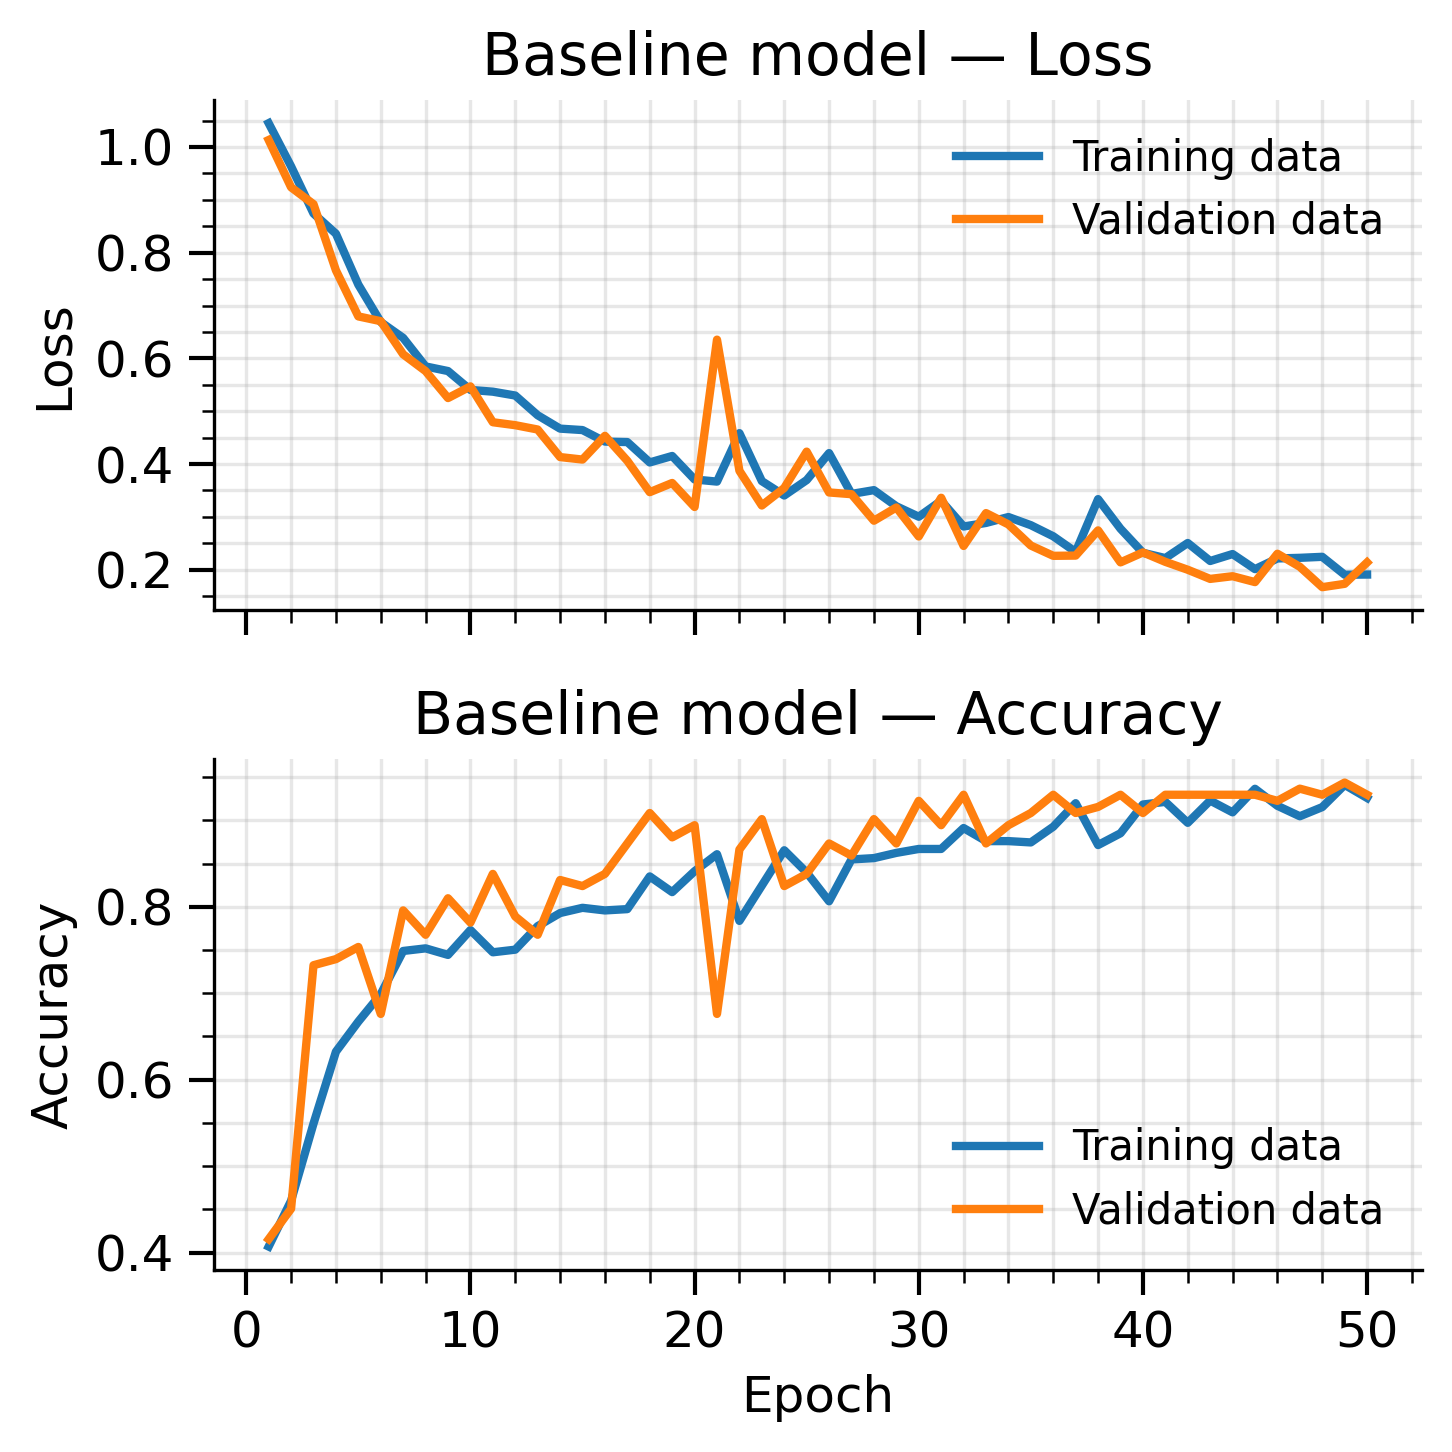

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "lines.linewidth": 2.0,
    "figure.dpi": 300,
})

hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

acc_key = "accuracy" if "accuracy" in hist else "acc"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

def finalize_axes(ax, ylabel, title, xlabel=None):
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(direction="out", length=6, width=1)
    ax.tick_params(which="minor", length=3)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(frameon=False)


fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)


axes[0].plot(epochs, hist["loss"], label="Training data")
axes[0].plot(epochs, hist["val_loss"], label="Validation data")
finalize_axes(axes[0], ylabel="Loss", title="Baseline model — Loss")

axes[1].plot(epochs, hist[acc_key], label="Training data")
axes[1].plot(epochs, hist[val_acc_key], label="Validation data")
finalize_axes(axes[1], ylabel="Accuracy", title="Baseline model — Accuracy", xlabel="Epoch")

plt.tight_layout()
fig.savefig("baseline_combined.pdf", bbox_inches="tight")
plt.show()


## Save model

In [11]:
baseline_model.save("baseline_model.keras")

# Ablation

## Utility functions and baseline metrics

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

AUTOTUNE = tf.data.AUTOTUNE
val_ds  = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

id_to_label = {v: k for k, v in label_to_id.items()}
class_names = [id_to_label[i] for i in range(len(label_to_id))]
num_classes = len(label_to_id)

def y_true_from_ds(ds):
    ys = []
    for _, y in ds:
        ys.append(y.numpy())
    return np.concatenate(ys, axis=0)

def evaluate_model(model, ds):
    """Return accuracy + macro/micro precision/recall/F1 on ds."""
    y_true = y_true_from_ds(ds)
    y_prob = model.predict(ds, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_true, y_pred)
    p_mac, r_mac, f_mac, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    p_mic, r_mic, f_mic, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )
    return {
        "accuracy": acc,
        "precision_macro": p_mac, "recall_macro": r_mac, "f1_macro": f_mac,
        "precision_micro": p_mic, "recall_micro": r_mic, "f1_micro": f_mic,
    }

def compile_baseline():
    """Rebuilds the baseline architecture (used by some ablations)."""
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

baseline_model = keras.models.load_model("baseline_model.keras")
baseline_val_metrics  = evaluate_model(baseline_model, val_ds)
baseline_test_metrics = evaluate_model(baseline_model, test_ds)

print("Baseline (saved model) — VAL:", baseline_val_metrics)
print("Baseline (saved model) — TEST:", baseline_test_metrics)

Baseline (saved model) — VAL: {'accuracy': 0.9295774647887324, 'precision_macro': 0.9371675943104515, 'recall_macro': 0.9305555555555555, 'f1_macro': 0.9280602726051979, 'precision_micro': 0.9295774647887324, 'recall_micro': 0.9295774647887324, 'f1_micro': 0.9295774647887324}
Baseline (saved model) — TEST: {'accuracy': 0.9647887323943662, 'precision_macro': 0.967948717948718, 'recall_macro': 0.9652777777777778, 'f1_macro': 0.9648499648499649, 'precision_micro': 0.9647887323943662, 'recall_micro': 0.9647887323943662, 'f1_micro': 0.9647887323943662}


## Batchnorm after each Conv

In [13]:
def build_bn_model():
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

bn_model = build_bn_model()
history_bn = bn_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
bn_model.save("ablation_bn.keras")

bn_val_metrics  = evaluate_model(bn_model, val_ds)
bn_test_metrics = evaluate_model(bn_model, test_ds)
print("BN — VAL:", bn_val_metrics)
print("BN — TEST:", bn_test_metrics)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.5957 - loss: 0.8822 - val_accuracy: 0.4014 - val_loss: 1.1055
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.7035 - loss: 0.6384 - val_accuracy: 0.3310 - val_loss: 1.2615
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.7889 - loss: 0.5100 - val_accuracy: 0.3732 - val_loss: 1.3955
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.7876 - loss: 0.4873 - val_accuracy: 0.4437 - val_loss: 1.5383
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.8097 - loss: 0.4812 - val_accuracy: 0.5704 - val_loss: 1.6483
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.8368 - loss: 0.4317 - val_accuracy: 0.5211 - val_loss: 1.8187
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.8448 - loss: 0.3976 - val_accuracy: 0.3451 - val_loss: 1.9098
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.8639 - loss: 0.4019 - val_accuracy: 0

## AdamW with weight_decay=1e-4

In [14]:
def build_baseline_adamw():
    model = compile_baseline()
    opt = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

adamw_model = build_baseline_adamw()
history_adamw = adamw_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
adamw_model.save("ablation_adamw.keras")

adamw_val_metrics  = evaluate_model(adamw_model, val_ds)
adamw_test_metrics = evaluate_model(adamw_model, test_ds)
print("AdamW — VAL:", adamw_val_metrics)
print("AdamW — TEST:", adamw_test_metrics)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.3150 - loss: 1.0772 - val_accuracy: 0.3521 - val_loss: 1.0349
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.4501 - loss: 0.9923 - val_accuracy: 0.6761 - val_loss: 0.9017
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.6306 - loss: 0.8633 - val_accuracy: 0.6761 - val_loss: 0.8060
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.6666 - loss: 0.7938 - val_accuracy: 0.7042 - val_loss: 0.7132
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.6882 - loss: 0.7296 - val_accuracy: 0.7113 - val_loss: 0.6549
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.6848 - loss: 0.6828 - val_accuracy: 0.7183 - val_loss: 0.6383
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.6975 - loss: 0.6438 - val_accuracy: 0.8099 - val_loss: 0.5623
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.7295 - loss: 0.5958 - val_accuracy: 0

## Label smoothing (eps=0.1)

In [15]:
def build_baseline_ls():
    model = compile_baseline()

    # Manual label smoothing implementation
    def smooth_loss(y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_pred)[-1], tf.float32)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        smooth_positives = 1.0 - 0.1   # epsilon = 0.1
        smooth_negatives = 0.1 / num_classes
        y_true_ls = y_true_one_hot * smooth_positives + smooth_negatives

        loss = -tf.reduce_sum(y_true_ls * tf.math.log(y_pred + 1e-7), axis=-1)
        return tf.reduce_mean(loss)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=smooth_loss,
        metrics=["accuracy"],
    )
    return model


ls_model = build_baseline_ls()
history_ls = ls_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
ls_model.save("ablation_labelsmooth.keras")

ls_val_metrics  = evaluate_model(ls_model, val_ds)
ls_test_metrics = evaluate_model(ls_model, test_ds)
print("Label Smoothing — VAL:", ls_val_metrics)
print("Label Smoothing — TEST:", ls_test_metrics)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.3511 - loss: 1.0779 - val_accuracy: 0.4507 - val_loss: 1.0197
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.5600 - loss: 0.9799 - val_accuracy: 0.6268 - val_loss: 0.9063
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.6455 - loss: 0.8626 - val_accuracy: 0.6831 - val_loss: 0.8326
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.6566 - loss: 0.8451 - val_accuracy: 0.7535 - val_loss: 0.7913
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.7079 - loss: 0.7859 - val_accuracy: 0.7254 - val_loss: 0.7483
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.6909 - loss: 0.7690 - val_accuracy: 0.7254 - val_loss: 0.7141
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.7201 - loss: 0.7126 - val_accuracy: 0.7465 - val_loss: 0.6999
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.7518 - loss: 0.6932 - val_accuracy: 0

In [16]:
def build_deeper_model():
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x);  x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x);  x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)  # +1 block
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

deep_model = build_deeper_model()
history_deep = deep_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
deep_model.save("ablation_deeper.keras")

deep_val_metrics  = evaluate_model(deep_model, val_ds)
deep_test_metrics = evaluate_model(deep_model, test_ds)
print("Deeper — VAL:", deep_val_metrics)
print("Deeper — TEST:", deep_test_metrics)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 483ms/step - accuracy: 0.3550 - loss: 1.0677 - val_accuracy: 0.5141 - val_loss: 0.9639
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.6266 - loss: 0.8810 - val_accuracy: 0.7042 - val_loss: 0.7434
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.7017 - loss: 0.7054 - val_accuracy: 0.7254 - val_loss: 0.5785
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.7397 - loss: 0.5731 - val_accuracy: 0.6901 - val_loss: 0.5550
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.7427 - loss: 0.5092 - val_accuracy: 0.7394 - val_loss: 0.5134
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8066 - loss: 0.4749 - val_accuracy: 0.7676 - val_loss: 0.6660
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.8151 - loss: 0.4489 - val_accuracy: 0.7042 - val_loss: 0.4853
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.8187 - loss: 0.3945 - val_accuracy: 

In [18]:
import pandas as pd

def to_row(name, val, test):
    return {
        "Method": name,
        "Val_Acc": val["accuracy"],
        "Val_F1_macro": val["f1_macro"],
        "Val_Prec_macro": val["precision_macro"],
        "Val_Rec_macro": val["recall_macro"],
        "Test_Acc": test["accuracy"],
        "Test_F1_macro": test["f1_macro"],
        "Test_Prec_macro": test["precision_macro"],
        "Test_Rec_macro": test["recall_macro"],
        # (optional) micro metrics
        "Test_F1_micro": test["f1_micro"],
        "Test_Prec_micro": test["precision_micro"],
        "Test_Rec_micro": test["recall_micro"],
    }

rows = [
    to_row("Baseline (saved)", baseline_val_metrics, baseline_test_metrics),
    to_row("BatchNorm", bn_val_metrics, bn_test_metrics),
    to_row("AdamW (wd=1e-4)", adamw_val_metrics, adamw_test_metrics),
    to_row("Label smoothing (ε=0.1)", ls_val_metrics, ls_test_metrics),
    to_row("Deeper (+1 block)", deep_val_metrics, deep_test_metrics),
]

df = pd.DataFrame(rows)
# nice rounding for paper
df_rounded = df.copy()
for c in df.columns:
    if c != "Method":
        df_rounded[c] = df[c].astype(float).round(4)

display(df_rounded)
df_rounded.to_csv("ablations_results.csv", index=False)
print("Saved metrics to ablations_results.csv")

# Quick LaTeX-friendly view (optional)
latex_cols = ["Method","Val_Acc","Val_F1_macro","Test_Acc","Test_F1_macro"]
print(df_rounded[latex_cols].to_string(index=False))


,Method,Val_Acc,Val_F1_macro,Val_Prec_macro,Val_Rec_macro,Test_Acc,Test_F1_macro,Test_Prec_macro,Test_Rec_macro,Test_F1_micro,Test_Prec_micro,Test_Rec_micro
0,Baseline (saved),0.9296,0.9281,0.9372,0.9306,0.9648,0.9648,0.9679,0.9653,0.9648,0.9648,0.9648
1,BatchNorm,0.9789,0.9787,0.9793,0.9792,0.9859,0.9860,0.9864,0.9861,0.9859,0.9859,0.9859
2,AdamW (wd=1e-4),0.9507,0.9505,0.9509,0.9514,0.9718,0.9718,0.9718,0.9719,0.9718,0.9718,0.9718
3,Label smoothing (ε=0.1),0.9155,0.9143,0.9235,0.9164,0.9648,0.9644,0.9664,0.9653,0.9648,0.9648,0.9648
4,Deeper (+1 block),0.9859,0.9859,0.9861,0.9861,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Saved metrics to ablations_results.csv
                 Method  Val_Acc  Val_F1_macro  Test_Acc  Test_F1_macro
       Baseline (saved)   0.9296        0.9281    0.9648         0.9648
              BatchNorm   0.9789        0.9787    0.9859         0.9860
        AdamW (wd=1e-4)   0.9507        0.9505    0.9718         0.9718
Label smoothing (ε=0.1)   0.9155        0.9143    0.9648         0.9644
      Deeper (+1 block)   0.9859        0.9859    1.0000         1.0000


# Transfer Learning with EfficientNetV2-B0

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
base = keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)
base.trainable = False
x = keras.layers.GlobalAveragePooling2D()(base.output)
x = keras.layers.Dropout(0.4)(x)
out = keras.layers.Dense(3, activation='softmax')(x)
model_tl = keras.Model(inputs=base.input, outputs=out)
model_tl.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
train_ds_resized = train_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
val_ds_resized   = val_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history_tl = model_tl.fit(
    train_ds_resized,
    validation_data=val_ds_resized,
    epochs=50,
    callbacks=[callback]
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5083 - loss: 0.9924 - val_accuracy: 0.8451 - val_loss: 0.5122
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.8224 - loss: 0.5223 - val_accuracy: 0.8873 - val_loss: 0.3356
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.8994 - loss: 0.3564 - val_accuracy: 0.9225 - val_loss: 0.2518
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.9258 - loss: 0.2592 - val_accuracy: 0.9225 - val_loss: 0.2064
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9320 - loss: 0.2291 - val_accuracy: 0.9577 - val_loss: 0.1679
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9551 - loss: 0.1841 - val_accuracy: 0.9577 - val_loss: 0.1413
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.9547 - loss: 0.1707 - val_accuracy: 0.9718 - val_loss: 0.1196
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - a

## Fine tuning transfer learning


In [22]:
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

model_tl.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_ft = model_tl.fit(
    train_ds_resized,
    validation_data=val_ds_resized,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9811 - loss: 0.0517 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.9888 - loss: 0.0419 - val_accuracy: 1.0000 - val_loss: 0.0115
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.9929 - loss: 0.0334 - val_accuracy: 1.0000 - val_loss: 0.0108
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.9892 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.9893 - loss: 0.0386 - val_accuracy: 1.0000 - val_loss: 0.0101
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9984 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9972 - loss: 0.0211 - val_accuracy: 1.00

In [32]:
model_tl.save("fine_tuned.keras")

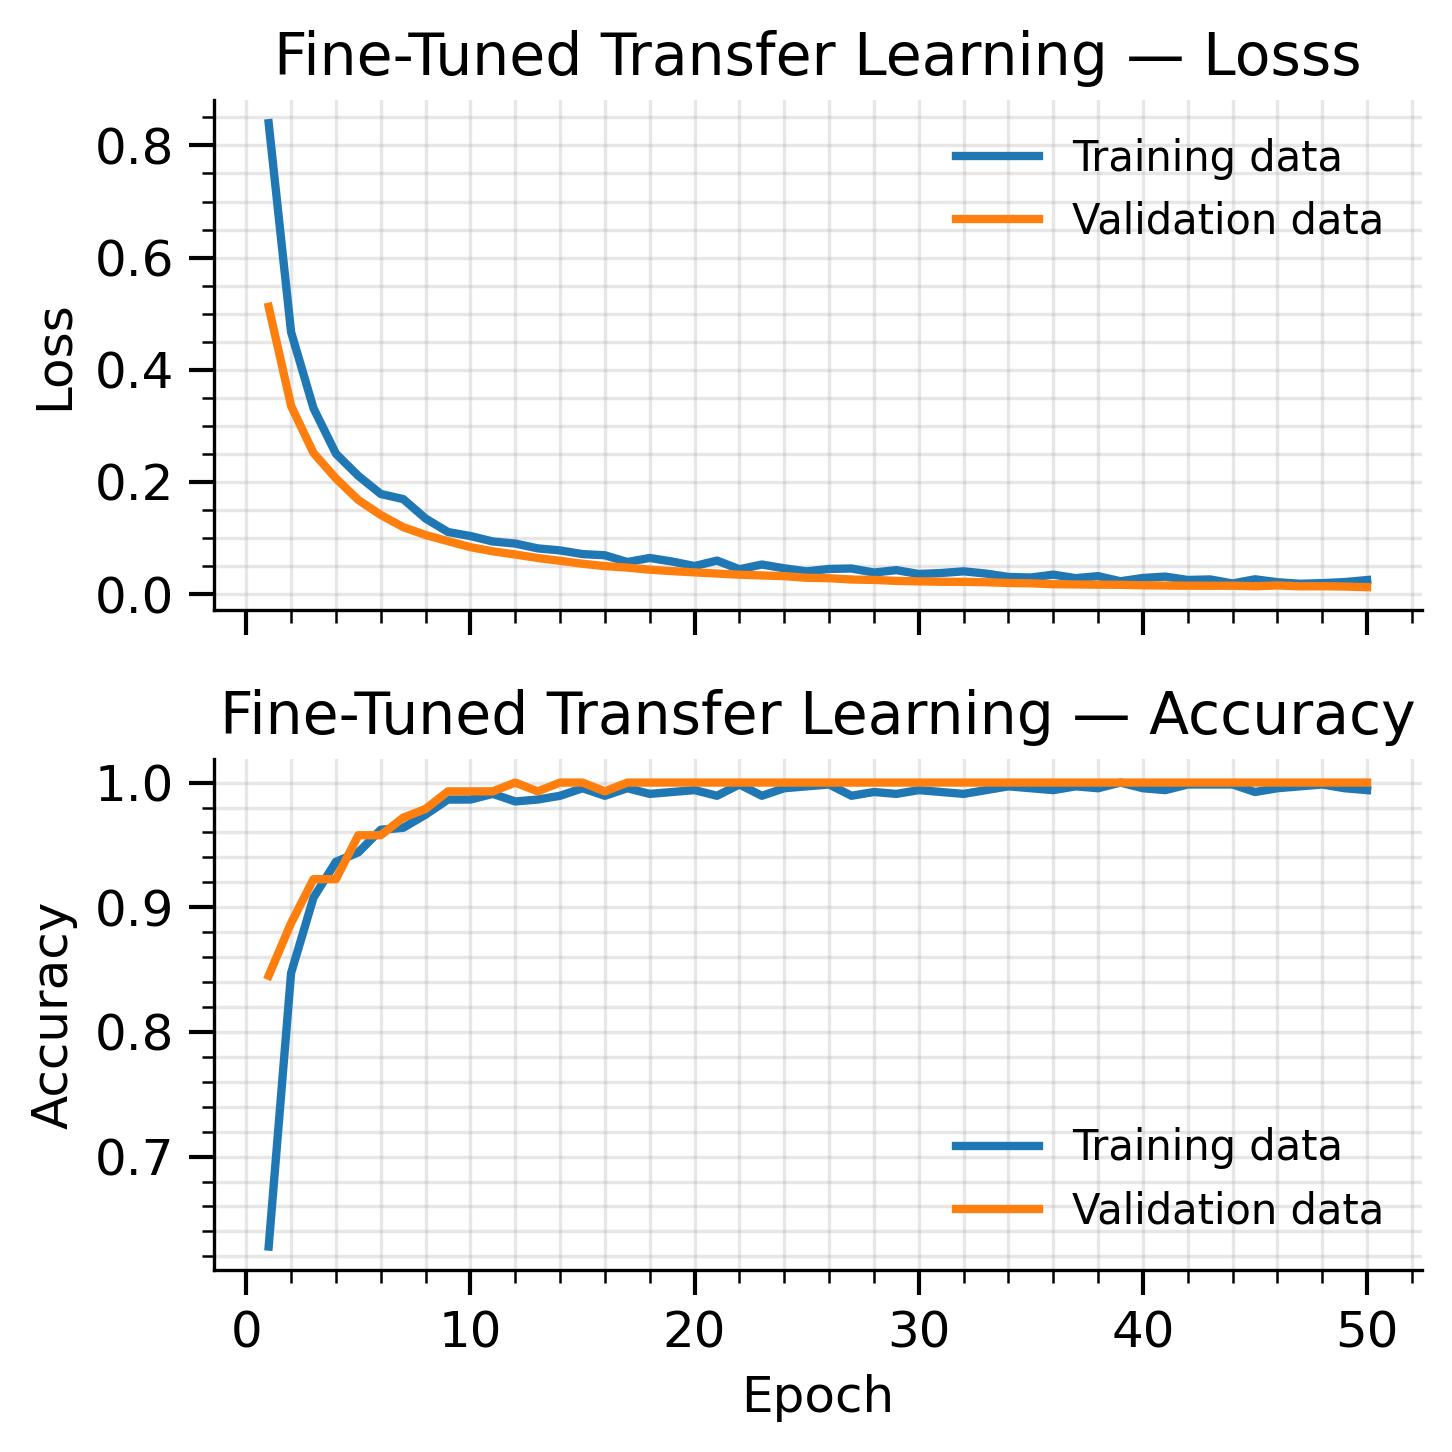

In [23]:
hist = history_tl.history
epochs = range(1, len(hist["loss"]) + 1)

acc_key = "accuracy" if "accuracy" in hist else "acc"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"


fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)


axes[0].plot(epochs, hist["loss"], label="Training data")
axes[0].plot(epochs, hist["val_loss"], label="Validation data")
finalize_axes(axes[0], ylabel="Loss", title="Fine-Tuned Transfer Learning — Losss")

axes[1].plot(epochs, hist[acc_key], label="Training data")
axes[1].plot(epochs, hist[val_acc_key], label="Validation data")
finalize_axes(axes[1], ylabel="Accuracy", title="Fine-Tuned Transfer Learning — Accuracy", xlabel="Epoch")

plt.tight_layout()
fig.savefig("finetuned_combined.pdf", bbox_inches="tight")
plt.show()


## Evaluation of Fine-Tuned EfficientNetV2-B0 Model



Test Accuracy: 1.000
Test Loss: 0.011

Classification Report:

              precision    recall  f1-score   support

      Corona      1.000     1.000     1.000        47
     Surface      1.000     1.000     1.000        48
    Internal      1.000     1.000     1.000        47

    accuracy                          1.000       142
   macro avg      1.000     1.000     1.000       142
weighted avg      1.000     1.000     1.000       142



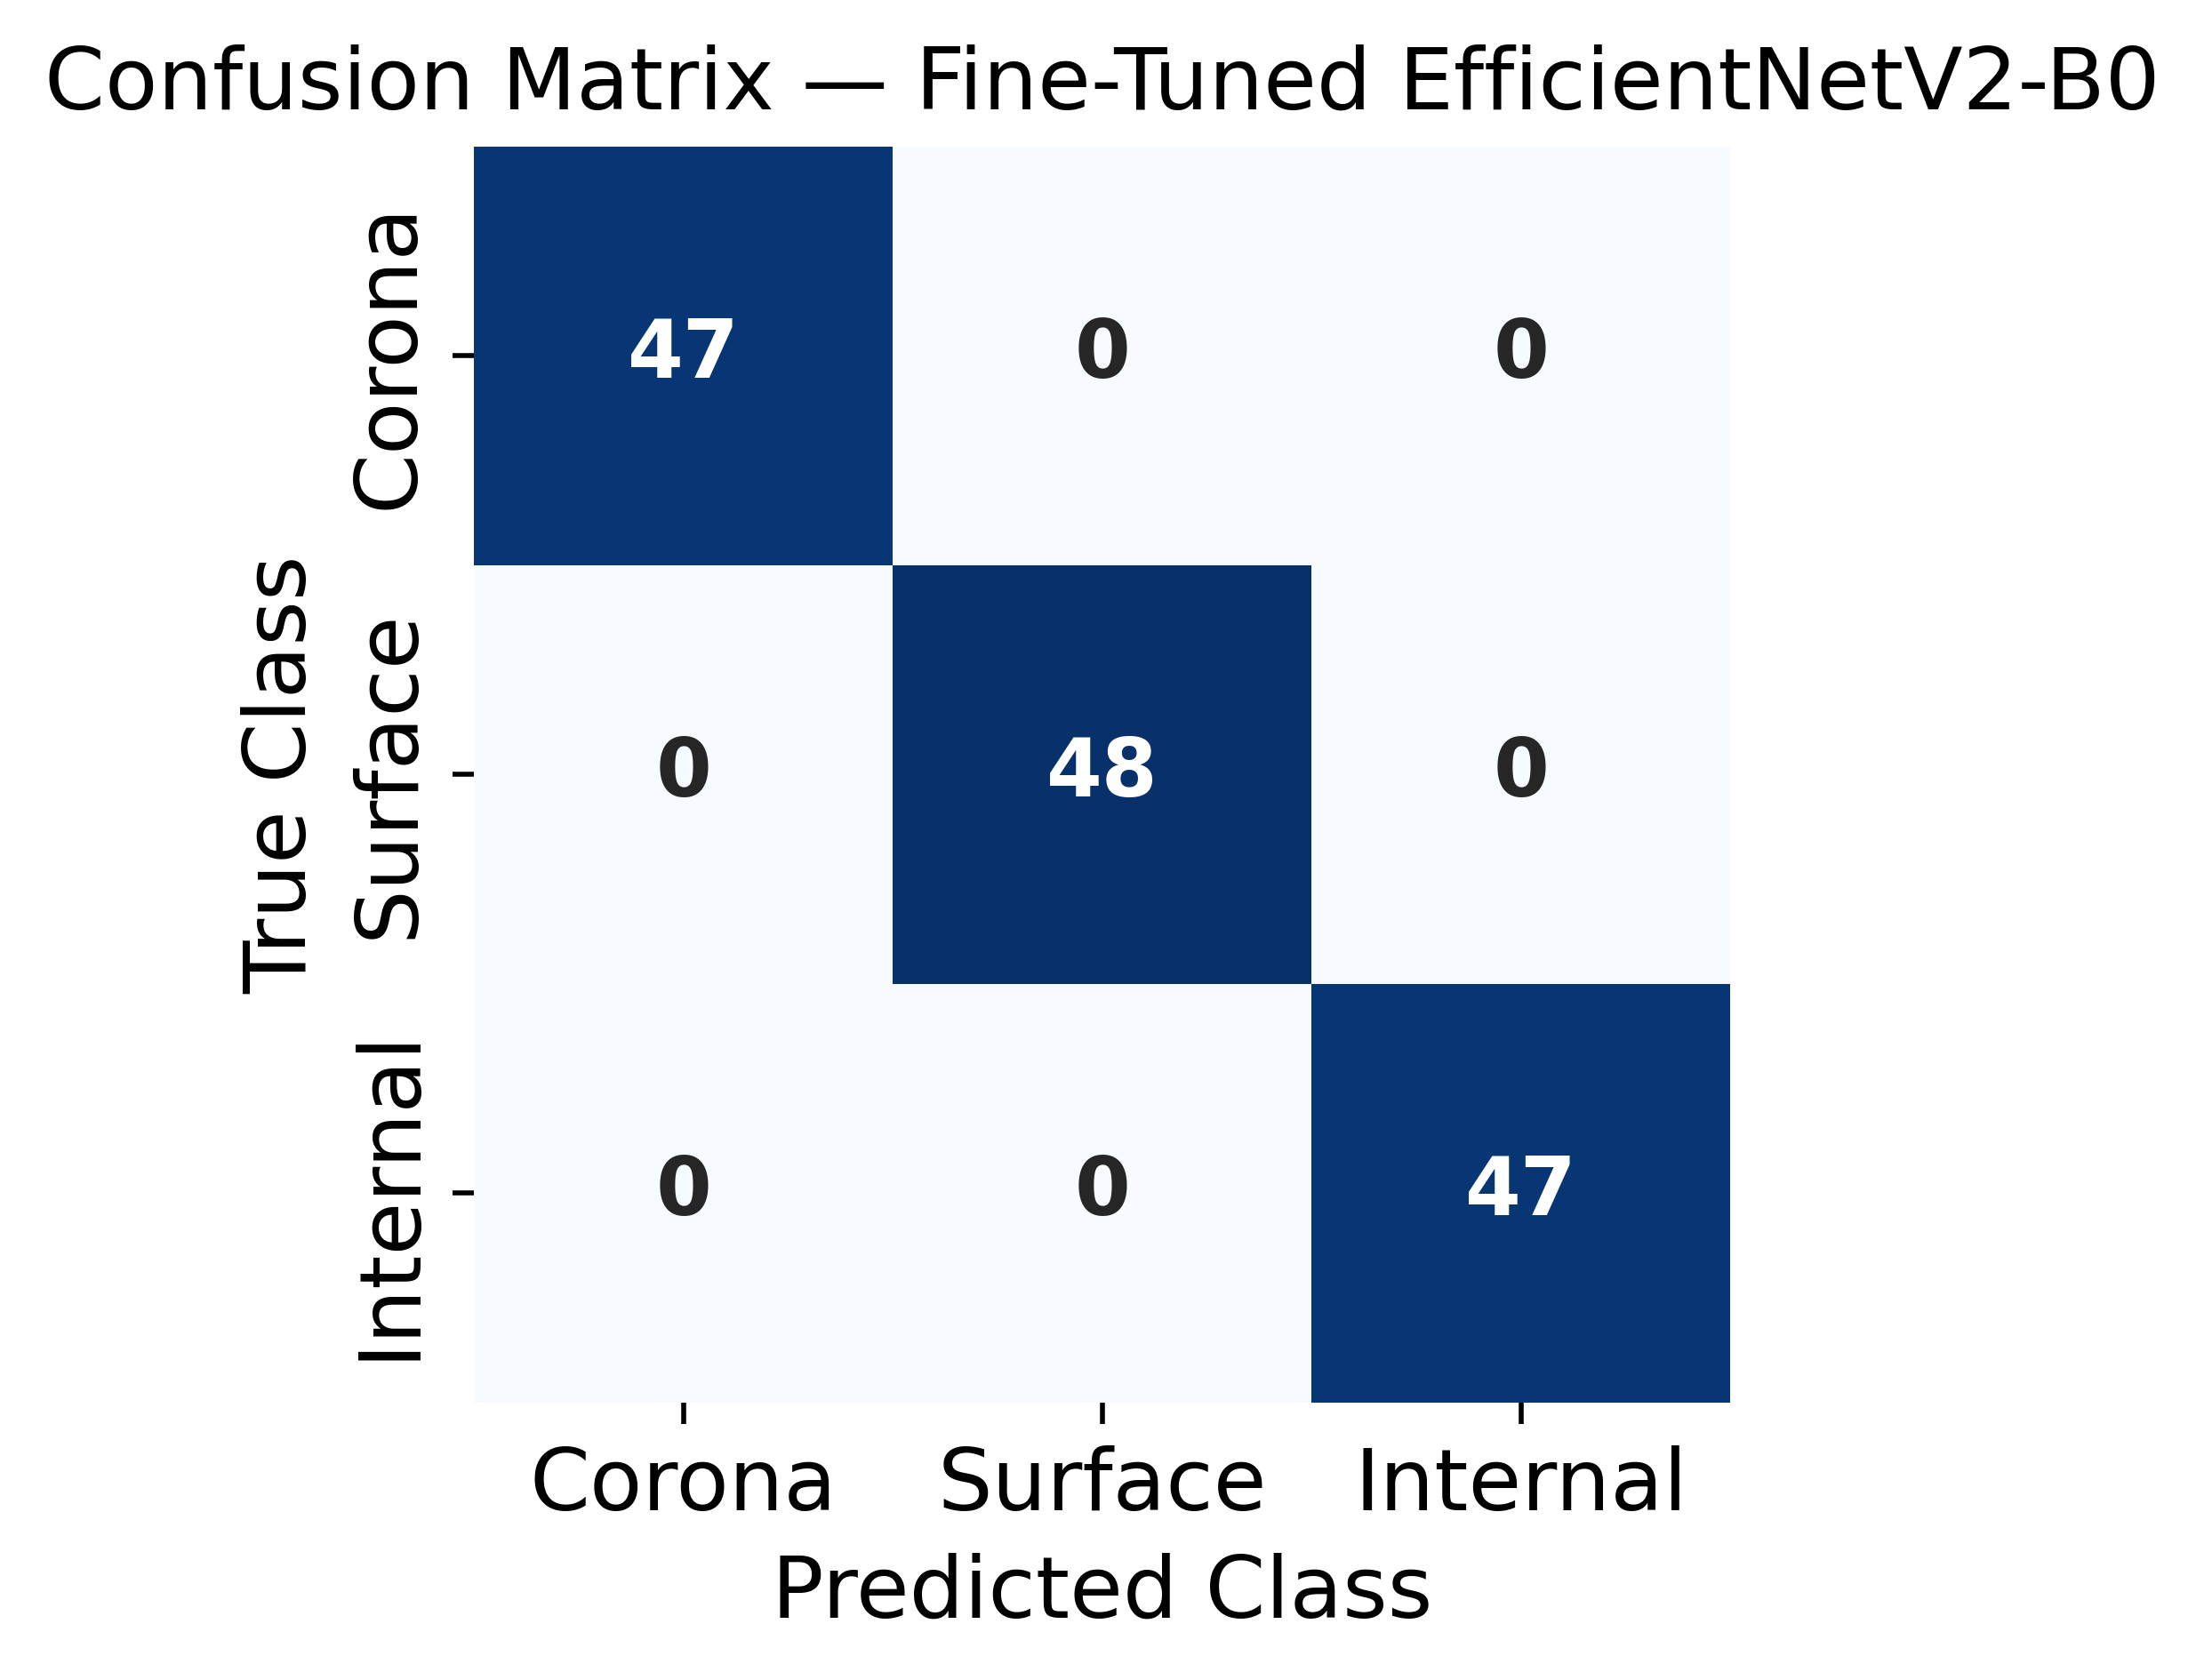

In [30]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model_tl.evaluate(test_ds, verbose=0)
print(f"\nTest Accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}")
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_prob = model_tl.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
class_names = ["Corona", "Surface", "Internal"]
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "figure.dpi": 500,
})
fig, ax = plt.subplots(figsize=(4.5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",  # 'd' = integer formatting for counts
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False,
    square=True,
    annot_kws={"size": 13, "fontweight": "bold"},
    ax=ax
)

ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_title("Confusion Matrix — Fine-Tuned EfficientNetV2-B0")
plt.tight_layout()

fig.savefig("confusion_matrix_finetuned.pdf", bbox_inches="tight")
plt.show()

# Visualization for Fine-Tuned EfficientNetV2-B0 Model

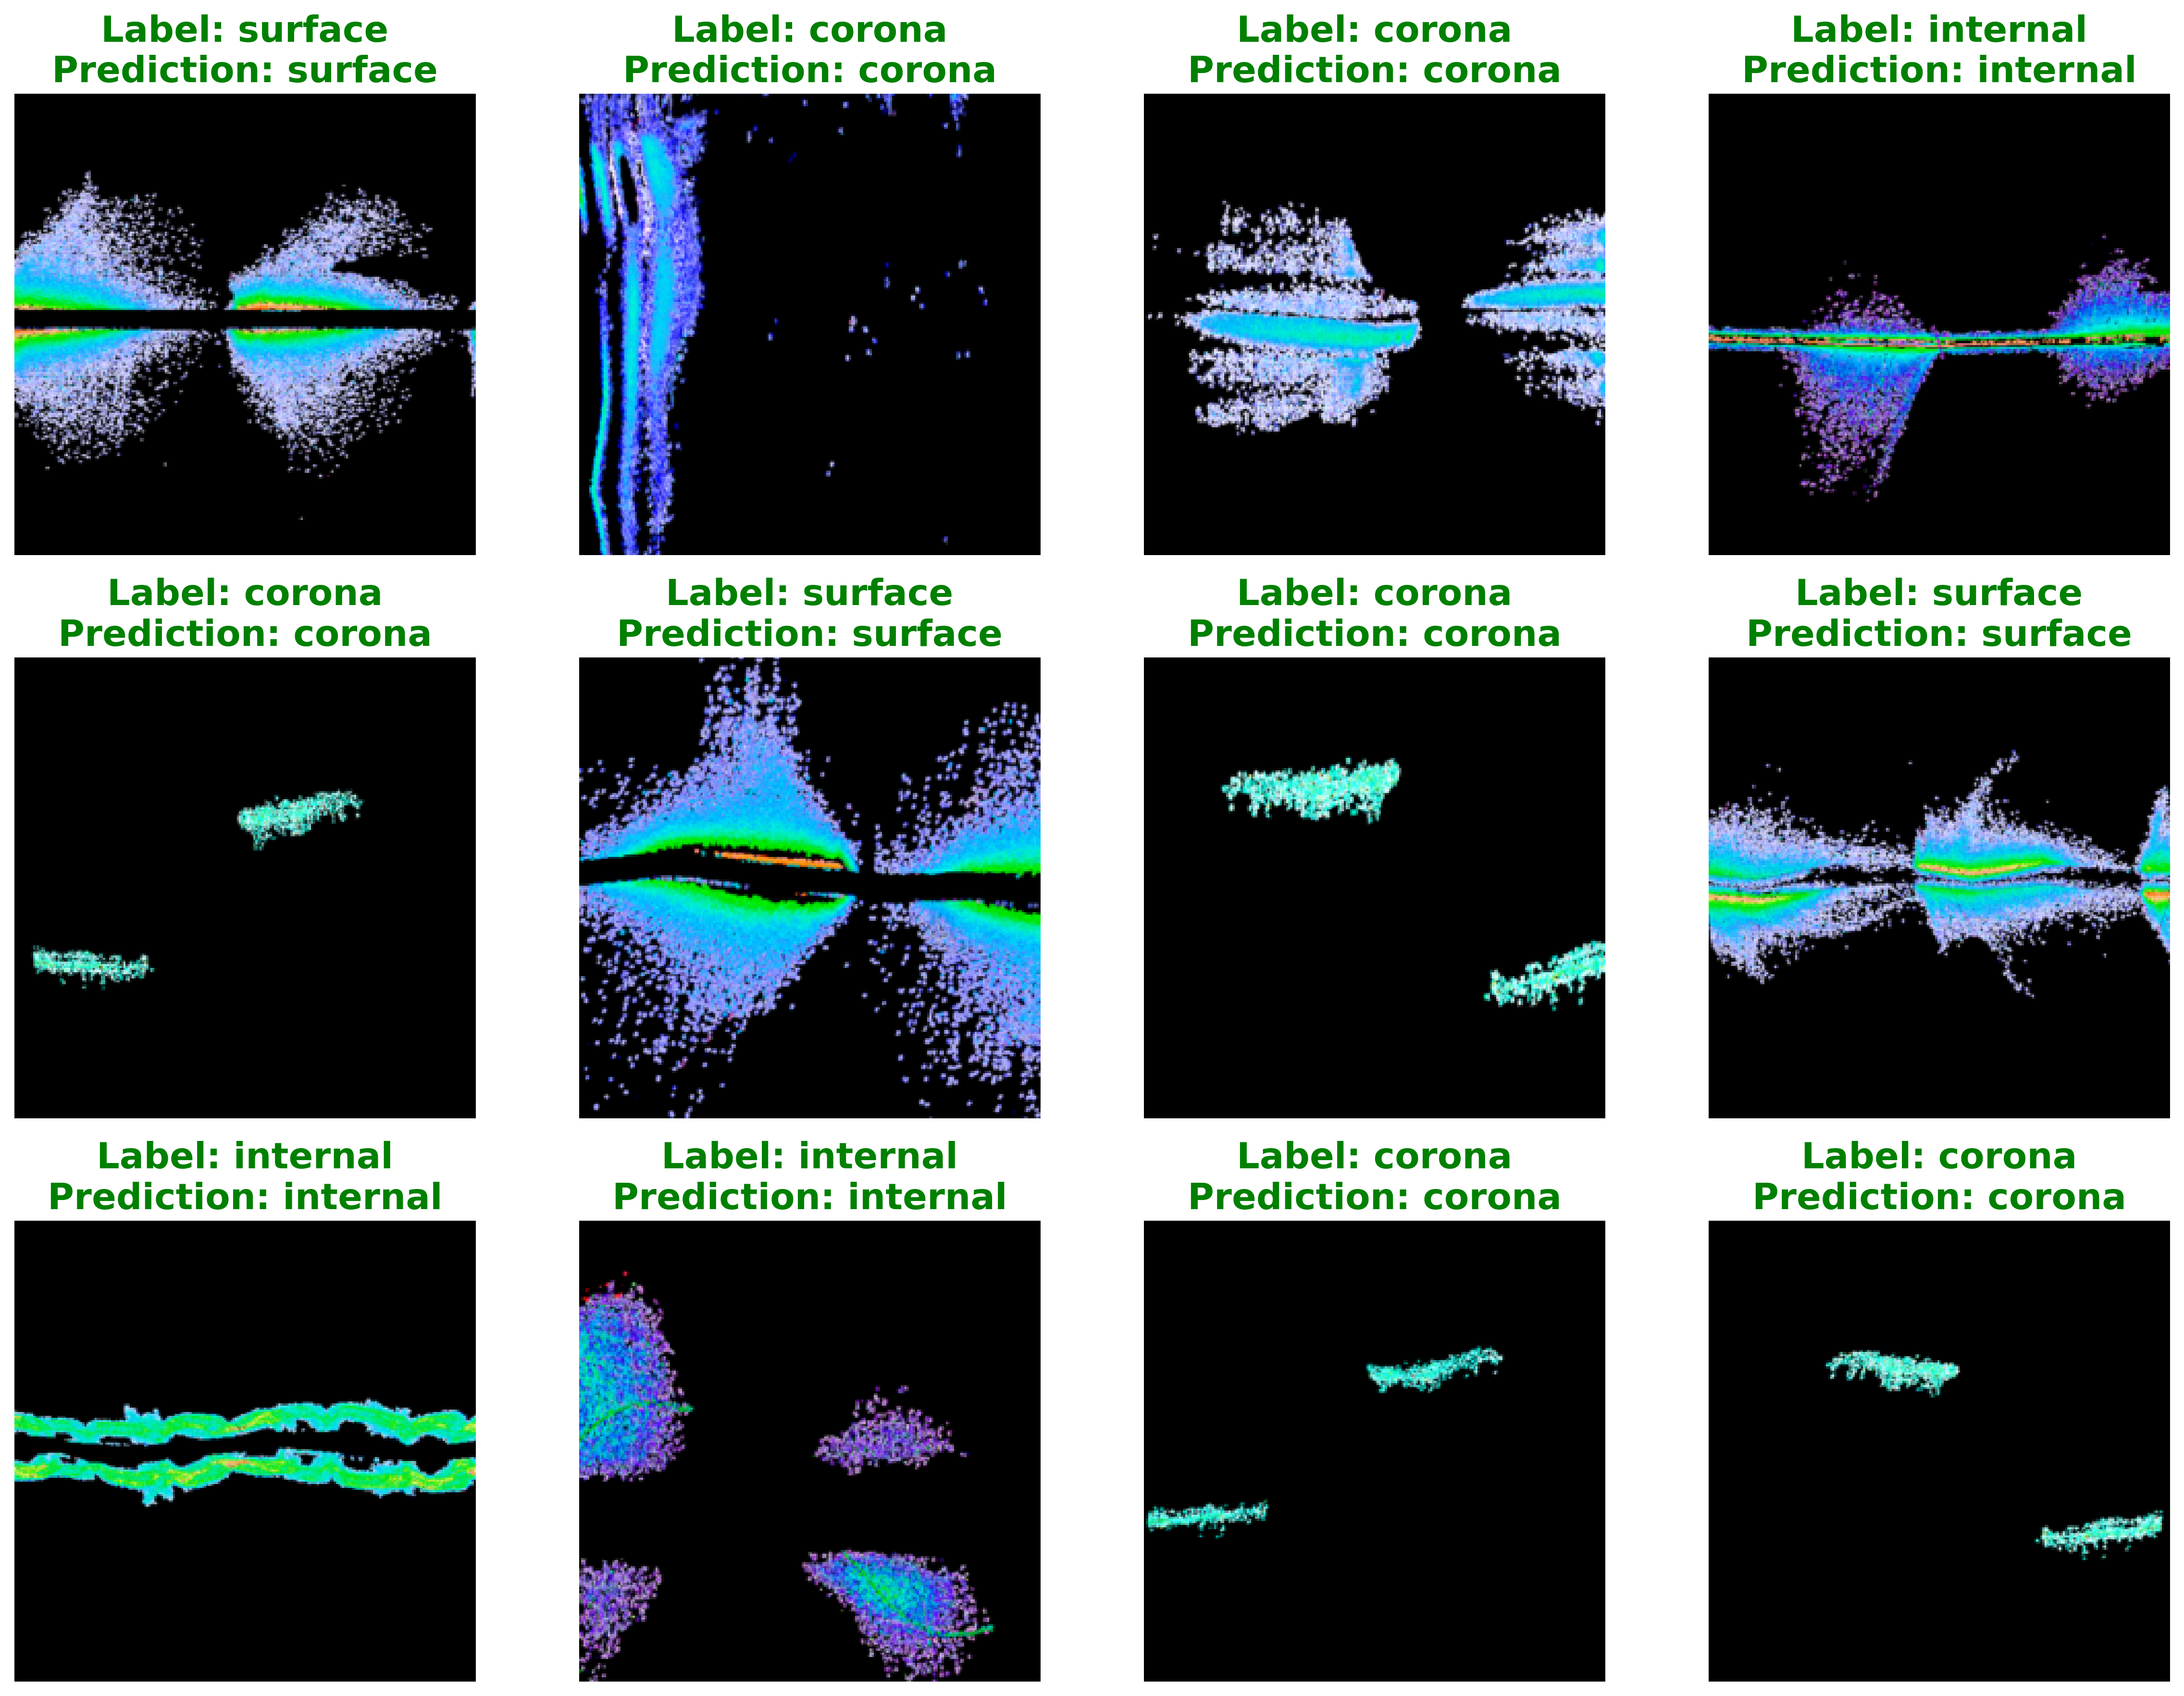

In [35]:
import matplotlib.pyplot as plt
import math
import numpy as np

sample_imgs, sample_lbls = next(iter(test_ds.unbatch().batch(12)))
probs = model_tl.predict(sample_imgs, verbose=0)
pred_ids = np.argmax(probs, axis=1)
conf = np.max(probs, axis=1)

cols, rows = 4, 3
n = sample_imgs.shape[0]

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "figure.dpi": 300,
})

plt.figure(figsize=(cols * 4.0, rows * 4.0))

for i in range(n):
    ax = plt.subplot(rows, cols, i + 1)
    img = sample_imgs[i].numpy().astype(np.uint8)
    true_id = int(sample_lbls[i].numpy())
    pred_id = int(pred_ids[i])
    p_conf = float(conf[i])
    true_label = id_to_label[true_id]
    pred_label = id_to_label[pred_id]
    correct = (true_id == pred_id)
    title_color = "green" if correct else "red"

    ax.imshow(img)
    ax.set_title(
        f"Label: {true_label}\nPrediction: {pred_label}",
        color=title_color,
        fontsize=18,
        weight="bold"
    )

    for spine in ax.spines.values():
        spine.set_edgecolor(title_color)
        spine.set_linewidth(2.5)

    ax.axis("off")

plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.8)

plt.savefig("fine_tuned_predictions.pdf", bbox_inches="tight")
plt.show()
